In [1]:
import os
import glob
import mne
import matplotlib.pyplot as plt
import numpy as np
import scipy
from fooof import FOOOF, FOOOFGroup, fit_fooof_3d
from fooof.sim.gen import gen_aperiodic

/tmp/ipykernel_18177/1120048852.py:7: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF, FOOOFGroup, fit_fooof_3d


In [2]:
c3_chans=['E30','E36','E41','E31','E37','E42','E54','E53']
c4_chans=['E105','E104','E103','E80','E87','E93','E79','E86']
c_chans=[]
c_chans.extend(c3_chans)
c_chans.extend(c4_chans)

In [34]:
def compute_psds(age):
    subjects=[os.path.split(x)[-1] for x in glob.glob('/home/common/bonaiuto/devmobeta/data/sub-*')]
    
    sub_psds=[]
    for subject in subjects:
        sub_path=os.path.join('/home/common/bonaiuto/devmobeta/derivatives/',subject)
        sessions=[os.path.split(x)[-1] for x in glob.glob(os.path.join(sub_path,'ses-*'))]
        for session in sessions:
            if (age=='3m' and (session=='ses-01' or session=='ses-02')) or (age=='6m' and (session=='ses-03' or session=='ses-04')) or (age=='12m' and (session=='ses-05' or session=='ses-06')):
                ses_path=os.path.join(sub_path, session)
                if os.path.exists(os.path.join(ses_path,'eeg','NEARICA_NF')):
                    eeg_path=os.path.join(ses_path,'eeg','NEARICA_NF')
                    fname=os.path.join(eeg_path, f'03_ica_data/{subject}_task-devmobeta_grasp_eeg_ica_art_rej_interp_reref.set')
                    if os.path.exists(fname):
                        raw_data=mne.io.read_raw_eeglab(fname, preload=True)
                        srate=raw_data.info['sfreq']

                        c_chan_idx=[]
                        for chan in c_chans:
                            if chan in raw_data.info['ch_names']:
                                c_chan_idx.append(raw_data.info['ch_names'].index(chan))
                        c_chan_idx=np.array(c_chan_idx)
                        
                        if len(c_chan_idx)==len(c_chans):
            
                            data=raw_data.get_data()
                            n_chans=data.shape[0]
                            n_samps=data.shape[1]

                            # Use a window size of 1s with a 50% overlap
                            winsize=srate
                            overlap=int(winsize/2)    

                            chan_data=data[c_chan_idx,:]
                            freqs, chan_psd=scipy.signal.welch(
                                chan_data, 
                                fs=srate, 
                                window='hann', 
                                nperseg=winsize, 
                                noverlap=overlap, 
                                nfft=int(winsize*20),
                                detrend='constant',
                                return_onesided=True, 
                                scaling='density', 
                                axis=- 1, 
                                average='mean'
                            )
                            f_idx=(freqs<=40)
                            freqs=freqs[f_idx]
                            chan_psd=chan_psd[:,f_idx]
                            sub_psds.append(chan_psd)
    sub_psds=np.array(sub_psds)
    return freqs, sub_psds

In [ ]:
freqs, sub_3m_psds=compute_psds('3m')
freqs, sub_6m_psds=compute_psds('6m')
freqs, sub_12m_psds=compute_psds('12m')

/tmp/ipykernel_18177/478601764.py:15: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_18177/478601764.py:15: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_18177/478601764.py:15: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_18177/478601764.py:15: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_18177/478601764.py:15: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload

/tmp/ipykernel_18177/478601764.py:15: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_18177/478601764.py:15: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_18177/478601764.py:15: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_18177/478601764.py:15: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_18177/478601764.py:15: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload

/tmp/ipykernel_18177/478601764.py:15: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_18177/478601764.py:15: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_18177/478601764.py:15: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_18177/478601764.py:15: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_18177/478601764.py:15: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload

/tmp/ipykernel_18177/478601764.py:15: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_18177/478601764.py:15: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_18177/478601764.py:15: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_18177/478601764.py:15: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_18177/478601764.py:15: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload

In [36]:
print(f'N 3m: {sub_3m_psds.shape[0]}')
print(f'N 6m: {sub_6m_psds.shape[0]}')
print(f'N 12m: {sub_12m_psds.shape[0]}')

N 3m: 40
N 6m: 25
N 12m: 6


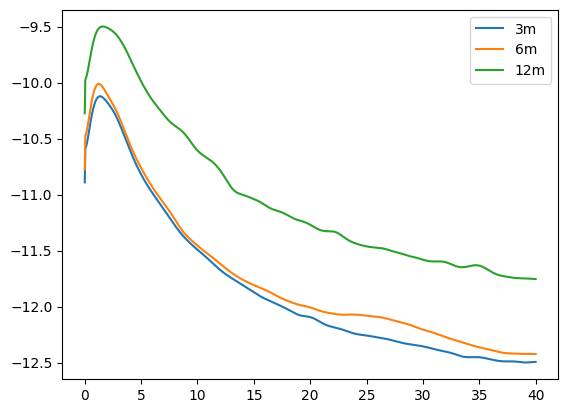

In [37]:
plt.plot(freqs,np.log10(np.mean(np.mean(sub_3m_psds,axis=1),axis=0)),label='3m')
plt.plot(freqs,np.log10(np.mean(np.mean(sub_6m_psds,axis=1),axis=0)),label='6m')
plt.plot(freqs,np.log10(np.mean(np.mean(sub_12m_psds,axis=1),axis=0)),label='12m')
plt.legend()

In [44]:
def parameterize_psds(freqs, sub_psds):
    n_chans=sub_psds.shape[1]
    fg = FOOOFGroup()
    fgs=fit_fooof_3d(fg, freqs, sub_psds, [.05, 40])
    
    sub_periodic=np.zeros(sub_psds.shape)
    sub_aperiodic=np.zeros(sub_psds.shape)
    for s_idx, fg in enumerate(fgs):
        for chan in range(n_chans):
            if chan in fg.null_inds_:
                sub_aperiodic[s_idx,chan,:]=float('NaN')
                sub_periodic[s_idx,chan,:]=float('NaN')
            else:
                fm = fg.get_fooof(ind=chan, regenerate=True)
                ap_params=fm.get_params('aperiodic_params')
                sub_aperiodic[s_idx,chan,:] = gen_aperiodic(freqs, ap_params)
                sub_periodic[s_idx,chan,:]=np.log10(sub_psds[s_idx,chan,:])-sub_aperiodic[s_idx,chan,:]
    return fgs, sub_periodic, sub_aperiodic

In [50]:
fgs_3m, sub_3m_periodic, sub_3m_aperiodic=parameterize_psds(freqs, sub_3m_psds)
fgs_6m, sub_6m_periodic, sub_6m_aperiodic=parameterize_psds(freqs, sub_6m_psds)
fgs_12m, sub_12m_periodic, sub_12m_aperiodic=parameterize_psds(freqs, sub_12m_psds)

Running FOOOFGroup across 640 power spectra.


/home/bonaiuto/miniconda3/envs/devmobeta/lib/python3.8/site-packages/fooof/core/funcs.py:87: RuntimeWarning: divide by zero encountered in log10
  ys = offset - np.log10(xs**exp)


Running FOOOFGroup across 400 power spectra.


/home/bonaiuto/miniconda3/envs/devmobeta/lib/python3.8/site-packages/fooof/core/funcs.py:87: RuntimeWarning: divide by zero encountered in log10
  ys = offset - np.log10(xs**exp)


Running FOOOFGroup across 96 power spectra.


/home/bonaiuto/miniconda3/envs/devmobeta/lib/python3.8/site-packages/fooof/core/funcs.py:87: RuntimeWarning: divide by zero encountered in log10
  ys = offset - np.log10(xs**exp)


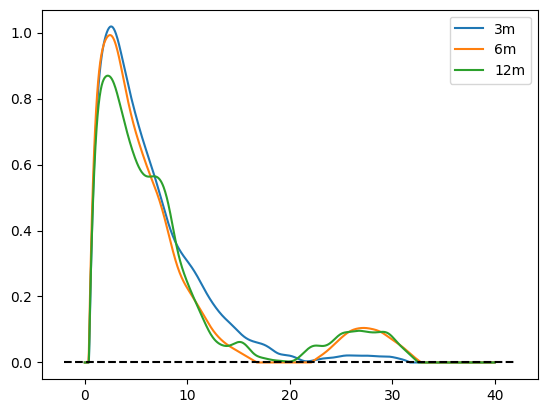

In [55]:
mean_psd_3m=np.mean(np.mean(sub_3m_periodic,axis=1),axis=0)
mean_psd_3m[mean_psd_3m<0]=0
mean_psd_6m=np.mean(np.mean(sub_6m_periodic,axis=1),axis=0)
mean_psd_6m[mean_psd_6m<0]=0
mean_psd_12m=np.mean(np.mean(sub_12m_periodic,axis=1),axis=0)
mean_psd_12m[mean_psd_12m<0]=0

plt.plot(freqs,mean_psd_3m,label='3m')
plt.plot(freqs,mean_psd_6m,label='6m')
plt.plot(freqs,mean_psd_12m,label='12m')
plt.plot(plt.xlim(), [0, 0],'k--')
plt.legend()

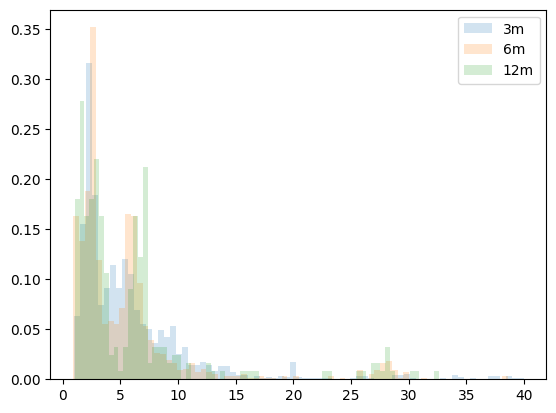

In [56]:
all_peaks_3m=[]
all_peaks_6m=[]
all_peaks_12m=[]
for s_idx, fg in enumerate(fgs_3m):
    for chan in range(len(c_chans)):
        fm = fg.get_fooof(ind=chan, regenerate=True)
        peaks=fm.get_params('peak_params','CF')
        if isinstance(peaks, np.ndarray):
            all_peaks_3m.extend(peaks)
        else:
            all_peaks_3m.append(peaks)
for s_idx, fg in enumerate(fgs_6m):
    for chan in range(len(c_chans)):
        fm = fg.get_fooof(ind=chan, regenerate=True)
        peaks=fm.get_params('peak_params','CF')
        if isinstance(peaks, np.ndarray):
            all_peaks_6m.extend(peaks)
        else:
            all_peaks_6m.append(peaks)
for s_idx, fg in enumerate(fgs_12m):
    for chan in range(len(c_chans)):
        fm = fg.get_fooof(ind=chan, regenerate=True)
        peaks=fm.get_params('peak_params','CF')
        if isinstance(peaks, np.ndarray):
            all_peaks_12m.extend(peaks)
        else:
            all_peaks_12m.append(peaks)
plt.hist(all_peaks_3m,75,alpha=.2,density=True,label='3m')
plt.hist(all_peaks_6m,75,alpha=.2,density=True,label='6m')
plt.hist(all_peaks_12m,75,alpha=.2,density=True,label='12m')
plt.legend()

In [66]:
def define_fois(freqs, mean_psd, debug=False):
    mean_resid=mean_psd
    foi_pk_freqs=[]
    foi_pk_vals=[]    
    foi_fwhms=[]
    foi_ranges=[]
    orig_pks,properties=scipy.signal.find_peaks(mean_resid)
    while True:
        pks,properties=scipy.signal.find_peaks(mean_resid)

        pk_vals=mean_resid[pks]
        sorted_idx=np.argsort(-pk_vals)
        pk_vals=pk_vals[sorted_idx]
        pks=pks[sorted_idx]

        pk_idx=pks[0]
        pk_val=pk_vals[0]
        pk_freq=freqs[pk_idx]
        
        if pk_val<np.std(mean_resid):
            if debug:
                print('Peak val={}, thresh={}'.format(pk_val,.5*np.std(mean_resid)))
            break

        
        l_idx=np.where(mean_resid[:pk_idx]<=pk_val*.5)[0]
        r_idx=np.where(mean_resid[pk_idx:]<=pk_val*.5)[0]

        if len(l_idx) and len(r_idx):
            l_freq=freqs[l_idx[-1]]
            r_freq=freqs[pk_idx+r_idx[0]]
            r_side=(r_freq-pk_freq)
            l_side=(pk_freq-l_freq)
            fwhm=2*np.min([r_side, l_side])
        elif len(l_idx):
            l_freq=freqs[l_idx[-1]]
            fwhm=2*(pk_freq-l_freq)
        elif len(r_idx):
            r_freq=freqs[pk_idx+r_idx[0]+1]
            fwhm=2*(r_freq-pk_freq)

        l_freq=pk_freq-fwhm*.5
        r_freq=pk_freq+fwhm*.5
        sd=fwhm/(2*np.sqrt(2*np.log(2)))
        A=pk_vals[0]*np.exp(-.5*((freqs-pk_freq)/sd)**2)
        nearest_orig=np.min(np.abs(freqs[np.array(orig_pks)]-pk_freq))
            
        if pk_val>np.std(mean_resid) and ((pk_freq<10 and fwhm>2) or (pk_freq>=10 and fwhm>2.4)):# and nearest_orig<3:
            print('Peak: freq={}, val={}, width={}, range={}-{}'.format(pk_freq, pk_val, fwhm, pk_freq-fwhm*.5, pk_freq+fwhm*.5))
            print('Distance to nearest original peak={}'.format(nearest_orig))
            if debug:
                plt.figure(figsize=(12,4))
                plt.subplot(1,2,1)
                plt.plot(freqs,mean_resid)
                plt.plot(freqs[pks],mean_resid[pks],'ro')
                plt.subplot(1,2,2)
                plt.plot(freqs,mean_resid)
                plt.plot(freqs,A)
            
            foi_pk_freqs.append(pk_freq)
            foi_pk_vals.append(pk_val)
            foi_fwhms.append(fwhm)
            foi_ranges.append([l_freq,r_freq])
        elif debug:
            if not ((pk_freq<10 and fwhm>2) or (pk_freq>=10 and fwhm>2.4)):
                print('Peak: freq={}, fhwm={} to narrow'.format(pk_freq, fwhm))
            if pk_val<=np.std(mean_resid):
                print('Peak: freq={} too low amplitude'.format(pk_freq))
            #if nearest_orig>=3:
            #    print('Peak: freq={} too far from original peaks'.format(pk_freq))

        mean_resid=mean_resid-A
        #mean_resid[mean_resid<0]=0
    sorted_idx=np.argsort(foi_pk_freqs)
    
    foi_pk_freqs=np.array(foi_pk_freqs)
    foi_pk_vals=np.array(foi_pk_vals)
    foi_fwhms=np.array(foi_fwhms)
    foi_ranges=np.array(foi_ranges)
    
    foi_pk_freqs=foi_pk_freqs[sorted_idx]
    foi_pk_vals=foi_pk_vals[sorted_idx]
    foi_fwhms=foi_fwhms[sorted_idx]
    foi_ranges=foi_ranges[sorted_idx,:]
    
    plt.figure()
    plt.plot(freqs,mean_psd)
    for f_idx in range(foi_ranges.shape[0]):
        sd=foi_fwhms[f_idx]/(2*np.sqrt(2*np.log(2)))
        A=foi_pk_vals[f_idx]*np.exp(-.5*((freqs-foi_pk_freqs[f_idx])/sd)**2)
        plt.plot(freqs,A)
    
    return foi_pk_freqs,foi_pk_vals,foi_fwhms,foi_ranges

Peak: freq=2.5500000000000003, val=1.0184656692969252, width=3.5000000000000004, range=0.8-4.300000000000001
Distance to nearest original peak=0.0
Peak: freq=6.1000000000000005, val=0.5744134805691624, width=3.9000000000000004, range=4.15-8.05
Distance to nearest original peak=3.5500000000000003
Peak: freq=10.15, val=0.2722435901394236, width=4.4, range=7.95-12.350000000000001
Distance to nearest original peak=7.6
Peak: freq=14.200000000000001, val=0.09243043044176585, width=3.900000000000002, range=12.25-16.150000000000002
Distance to nearest original peak=11.549999999999999


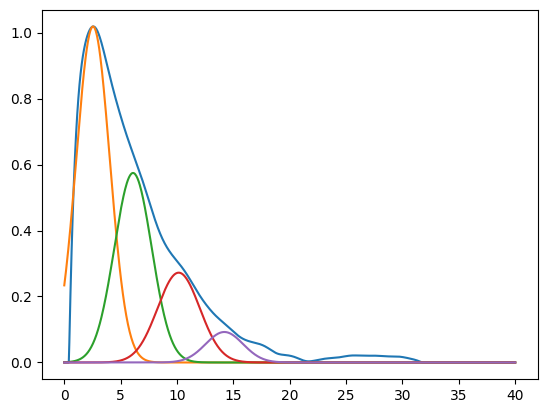

In [70]:
foi_pk_freqs_3m,foi_pk_vals_3m,foi_fwhms_3m,foi_ranges_3m=define_fois(freqs, mean_psd_3m, debug=False)

Peak: freq=2.45, val=0.9923137747081054, width=3.5, range=0.7000000000000002-4.2
Distance to nearest original peak=0.0
Peak: freq=6.050000000000001, val=0.5429566141165558, width=4.000000000000002, range=4.05-8.05
Distance to nearest original peak=3.6000000000000005
Peak: freq=9.950000000000001, val=0.1892089719303337, width=4.800000000000001, range=7.550000000000001-12.350000000000001
Distance to nearest original peak=7.500000000000001
Peak: freq=27.200000000000003, val=0.10469551424348361, width=5.900000000000006, range=24.25-30.150000000000006
Distance to nearest original peak=0.0


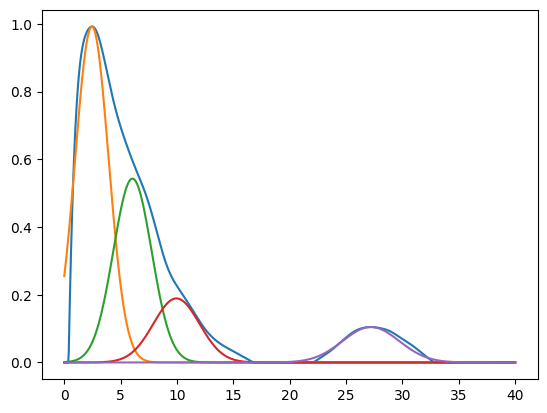

In [72]:
foi_pk_freqs_6m,foi_pk_vals_6m,foi_fwhms_6m,foi_ranges_6m=define_fois(freqs, mean_psd_6m, debug=False)

Peak: freq=2.25, val=0.8693534557528163, width=3.0999999999999996, range=0.7000000000000002-3.8
Distance to nearest original peak=0.0
Peak: freq=6.8500000000000005, val=0.5621876049691422, width=5.500000000000002, range=4.1-9.600000000000001
Distance to nearest original peak=0.10000000000000053
Peak: freq=26.75, val=0.09615093934206739, width=8.300000000000004, range=22.599999999999998-30.900000000000002
Distance to nearest original peak=0.0
Peak: freq=15.15, val=0.0606811382725754, width=2.400000000000002, range=13.95-16.35
Distance to nearest original peak=0.049999999999998934


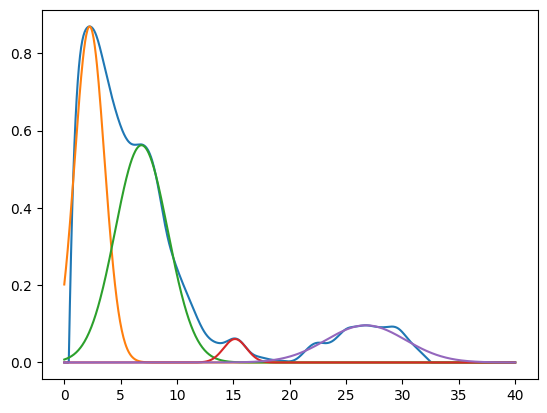

In [73]:
foi_pk_freqs_12m,foi_pk_vals_12m,foi_fwhms_12m,foi_ranges_12m=define_fois(freqs, mean_psd_12m, debug=False)